# Qiskit cold atom

https://github.com/Qiskit-Extensions/qiskit-cold-atom

**Goal:** simulate $e^{-i\hat{H}t}$

* We can use a *universal quantum computer*, e.g., IBM Quantum, and decompose $e^{-i\hat{H}t}$ into a quantum circuit.
    * Typically, these circuits are very deep e.g. due to Trotterization 
    * Covered by Qiskit.
* Alternatively, build a dedicated machine, *not universal*, that natively implements $\hat{H}$.
    * Cold-atomic simulators trap particles in optical latices: 
        * Fermions
        * Bose-Einstein Condensates that form long spins
    * Not described by qubits
    
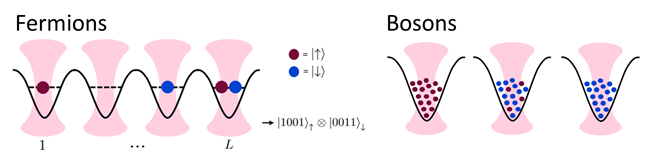
    
**Can we describe and control these machines in Qiskit?**

## Qiskit Cold Atom

* Providers and simulators for fermionic- and spin-based cold atomic hardware
* Designed to abstract cold-atomic experiments
* Designed to work for remote hardware and simulators
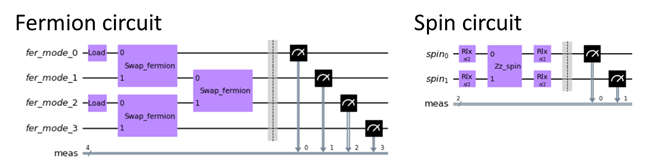

In [18]:
from qiskit_cold_atom.providers import ColdAtomProvider

provider = ColdAtomProvider()

for backend in provider.backends():
    print(backend)

fermion_simulator
spin_simulator
fermionic_tweezer_simulator
collective_spin_simulator


## Example 1: squeezing a long spin

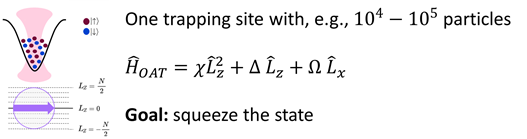

* Entanglement between the particles can reduce the variance in the collective $L_z$-operator
    * $\Longrightarrow$ squeezing
* Squeezing enhances sensitivity to, e.g., magnetic fields and phases

### Non-squeezed state

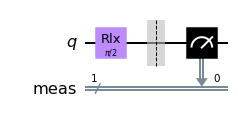

In [2]:
import numpy as np
from qiskit import QuantumCircuit
backend = provider.get_backend("collective_spin_simulator")

circ_x = QuantumCircuit(1)
circ_x.rlx(np.pi/2, 0)
circ_x.measure_all()

circ_x.draw("mpl")

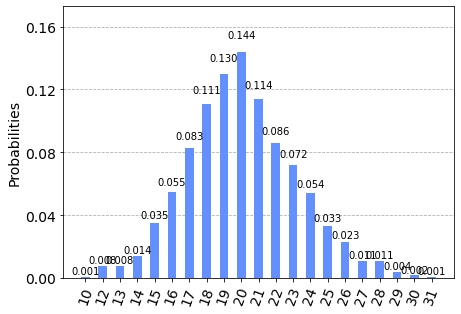

In [3]:
from qiskit.visualization import plot_histogram

job_x = backend.run(circ_x, shots = 1000, spin=20, seed=14)
plot_histogram(job_x.result().get_counts())

### Squeezed state

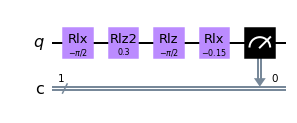

In [4]:
squeez_circ = QuantumCircuit(1, 1)
squeez_circ.rlx(-np.pi/2, 0)
squeez_circ.rlz2(0.3, 0)
squeez_circ.rlz(-np.pi/2, 0)
squeez_circ.rlx(-0.15, 0)
squeez_circ.measure(0, 0)

squeez_circ.draw(output='mpl')

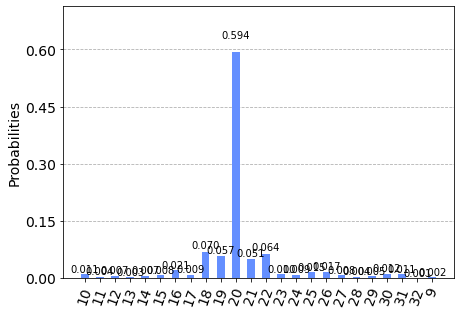

In [5]:
job_squeez = backend.run(squeez_circ, shots = 1000, spin=20, seed=14)
plot_histogram(job_squeez.result().get_counts())

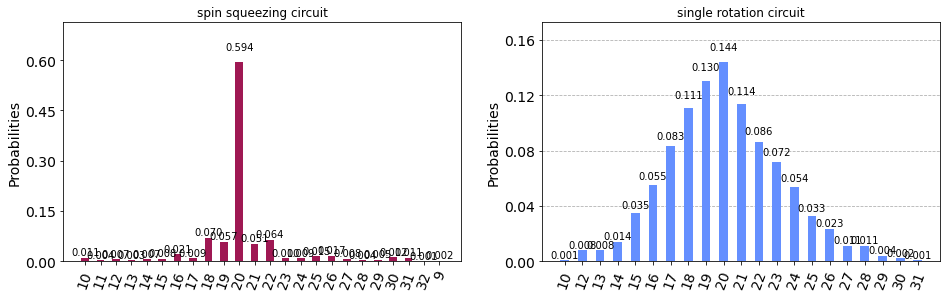

In [6]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.tight_layout(pad=5.0)
ax1.set_title("spin squeezing circuit")
ax2.set_title("single rotation circuit")

plot_histogram(job_x.result().get_counts(), ax=ax2)
plot_histogram(job_squeez.result().get_counts(), ax=ax1, color="#9f1853")

## Example 2: fermionic time-evolution

The problem `FermionicEvolutionProblem` is a time evolution of a fermionic lattice system, after which an observable is measured. 
It consists of the following steps:

* The `system`: a 1-dimensional Fermi-Hubbard model with spin-$\frac{1}{2}$ fermions described by the Hamiltonian:
    $$ H_{\text{FH}} =  J{\sum_{i=1,\sigma}^{L-1} (f^\dagger_{i,\sigma} f_{i+1,\sigma} + f^\dagger_{i+1,\sigma} f_{i,\sigma} )} + {U \sum_{i=1}^{L}  n_{i,\uparrow}n_{i,\downarrow}} + {\sum_{i=1,\sigma}^{L} \mu_i n_{i,\sigma}} $$   
$J$ is the strength of the hopping between neighboring sites, $U$ is the interaction strength of two atoms on the same site, and $\mu_i$ describe local potential offsets.

In [7]:
from qiskit_cold_atom.applications import FermiHubbard1D

# defining the system 
system = FermiHubbard1D(
    num_sites = 3,          # number of lattice sites
    particles_up = 1,       # number of spin up particles
    particles_down = 1,     # number of spin down particles
    hop_strength = 2.,      # parameter J tuning the hopping 
    int_strength = 1,       # parameter U tuning the interaction
    potential = [1, 0, -1]  # parameters mu tuning the local potential
)

### Setting up the problem

* The system is initialized in a state given as a `FermionicState` object, which describes states in occupation number basis. 
* The occupations are given as a nested list: the first list are spin-$\uparrow$ particles & the second list are spin-$\downarrow$ particles.

In [8]:
from qiskit_cold_atom.fermions.fermion_circuit_solver import FermionicState

# One spin_up particle in the left site & one spin-down particle in the right site
initial_state = FermionicState([[1, 0, 0], [0, 0, 1]])

* Qiskit Nature's `FermionicOp` is used to define the observables to measure

In [17]:
from qiskit_nature.operators.second_quantization import FermionicOp

spin_density = FermionicOp([('NIIIII', 1), ('IIINII', -1)])

evolution_times = np.linspace(0.1, 5, 40) # times to simulate

* Define a `FermionicEvolutionProblem` for the observable:

In [10]:
from qiskit_cold_atom.applications import FermionicEvolutionProblem

spin_problem = FermionicEvolutionProblem(system, initial_state, evolution_times, spin_density)

### Solving the problem

Compare simulators of fermionic hardware and of qubit-based hardware.

* Fermionic hardware

In [11]:
from qiskit_cold_atom.providers.fermionic_tweezer_backend import FermionicTweezerSimulator
from qiskit_cold_atom.applications import TimeEvolutionSolver

fermionic_backend = FermionicTweezerSimulator(n_tweezers=3)
fermionic_solver = TimeEvolutionSolver(backend = fermionic_backend)

* Qubit-based hardware

In [12]:
from qiskit import Aer

qubit_backend = Aer.get_backend('qasm_simulator')

mapping = 'bravyi_kitaev'  # or 'jordan_wigner', 'parity'

shallow_qubit_solver = TimeEvolutionSolver(backend = qubit_backend, map_type = mapping, trotter_steps = 1)
deep_qubit_solver = TimeEvolutionSolver(backend = qubit_backend, map_type = mapping, trotter_steps = 6)

### Solving the problem

In [13]:
spin_vals_fermions = fermionic_solver.solve(spin_problem)
spin_vals_qubits_shallow = shallow_qubit_solver.solve(spin_problem)
spin_vals_qubits_deep = deep_qubit_solver.solve(spin_problem)

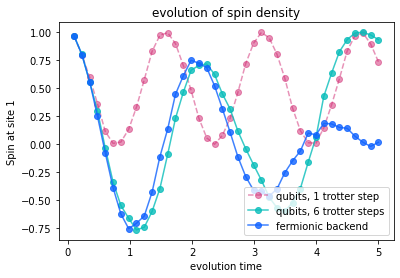

In [14]:
plt.xlabel('evolution time')
plt.ylabel('Spin at site 1')
plt.title('evolution of spin density')
plt.plot(evolution_times, spin_vals_qubits_shallow, '--o', color='#d02670', alpha=0.5, label='qubits, 1 trotter step')
plt.plot(evolution_times, spin_vals_qubits_deep, '-o', color='#08bdba', alpha=0.8, label='qubits, 6 trotter steps')
plt.plot(evolution_times, spin_vals_fermions, '-o', color='#0f62fe', alpha=0.8, label='fermionic backend')
plt.legend()

### The quantum circuits

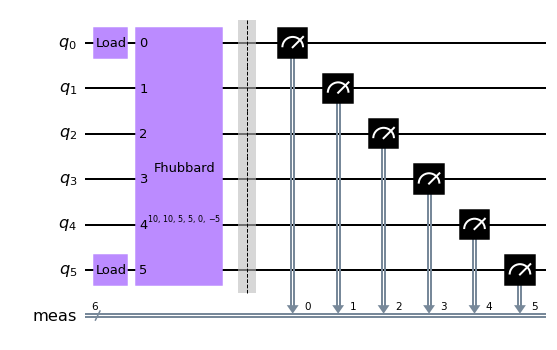

In [15]:
fermion_circuit = spin_problem.circuits(fermionic_backend.initialize_circuit(initial_state.occupations))[-1]
fermion_circuit.measure_all()
fermion_circuit.draw(output='mpl')

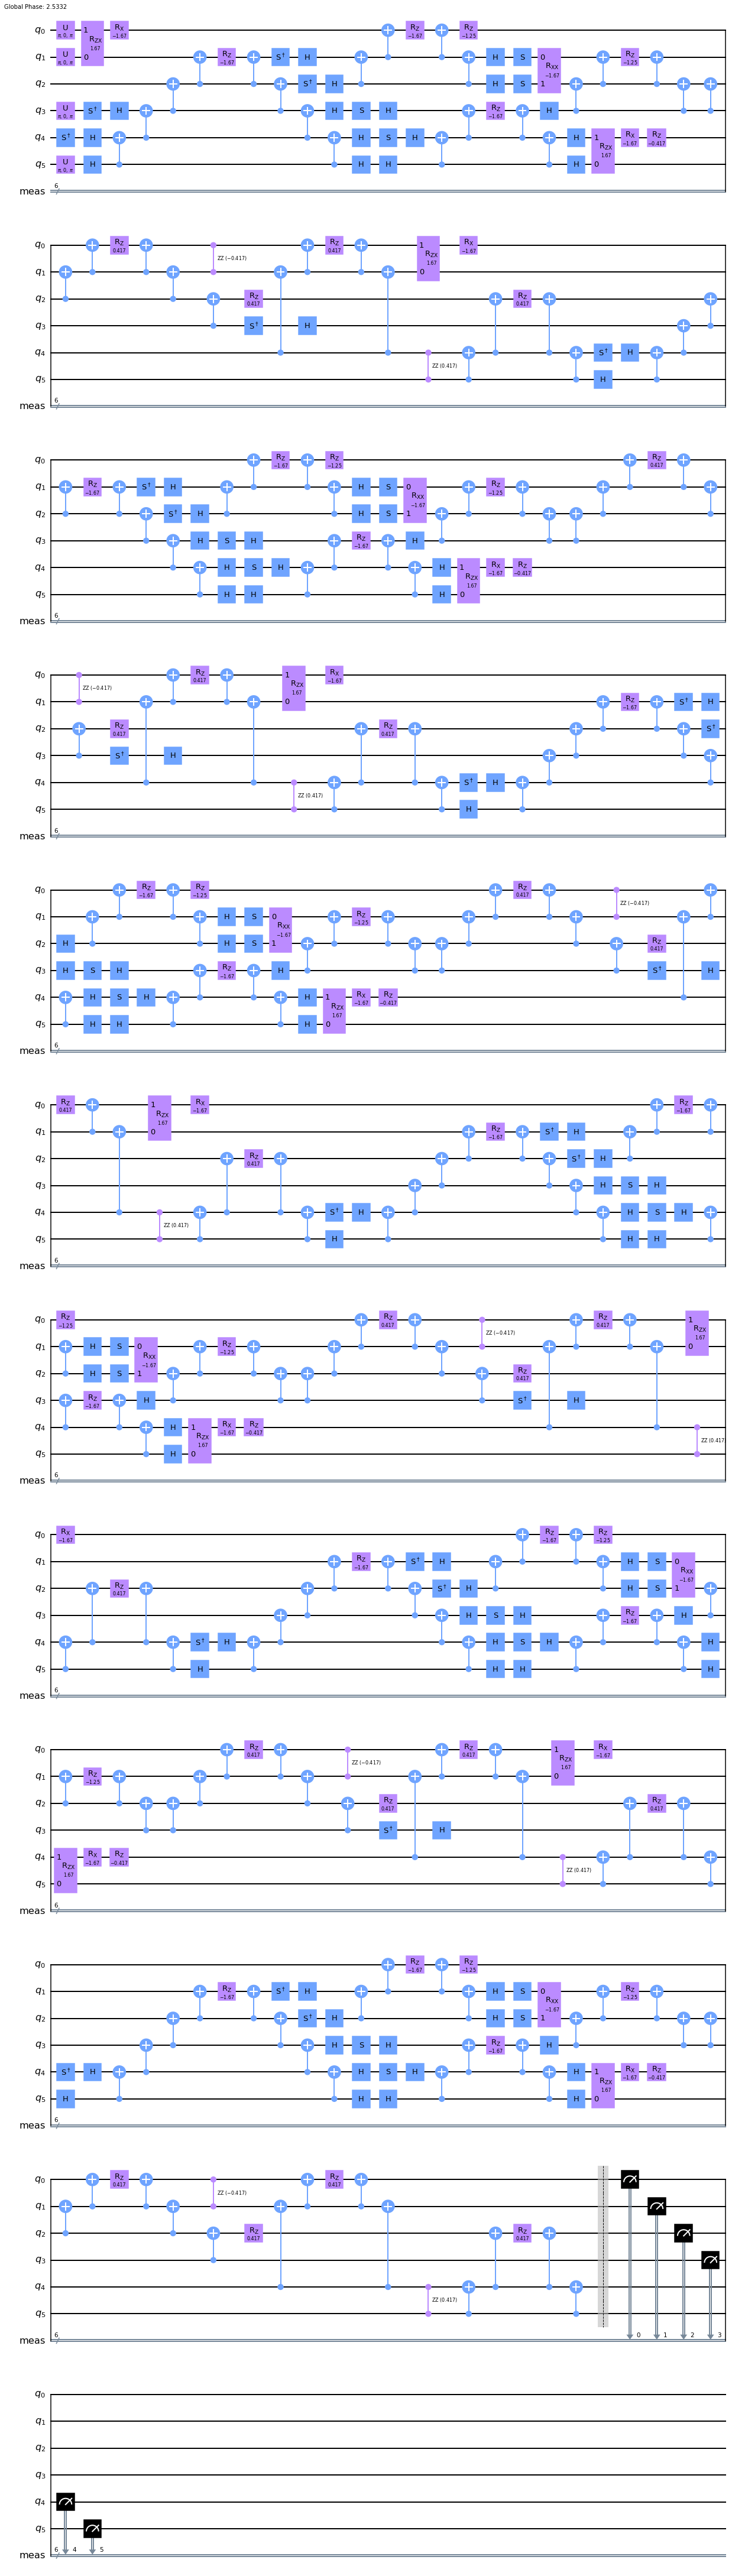

In [16]:
qubit_circuit = deep_qubit_solver.construct_qubit_circuits(spin_problem)[-1]
qubit_circuit.measure_all()
qubit_circuit.decompose().decompose().draw("mpl", idle_wires=False)

## Conclusion

Qiskit-cold-atom
* Demonstrates how non-qubit-based hardware can be controlled with Qiskit.
* Abstracts many hardware-level details opening such setups to a wider audience.

Repository: https://github.com/Qiskit-Extensions/qiskit-cold-atom

Docs: https://qiskit-extensions.github.io/qiskit-cold-atom/

Pypi: https://pypi.org/project/qiskit-cold-atom/